In [67]:
import os
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import Chroma

def vct_db_filename_gen(file_path):
    # Derive vector DB filename from CSV filename
    base_name = os.path.basename(file_path)
    db_file_name = os.path.splitext(base_name)[0] + ".vecdb"

    return os.path.join(os.path.dirname(file_path), db_file_name)

def check_and_load_vector_db(file_path, embedding):
    """
    Checks if a vector db file exists for the given file_path, 
    loads it if exists, otherwise creates it from the csv and saves it.
    """
    # Derive vector DB filename from CSV filename
    db_file_path = vct_db_filename_gen(file_path)

    # Check if the vector DB file exists
    if os.path.exists(db_file_path):
        print(f"Loading existing vector DB from {db_file_path}")
        db = Chroma(persist_directory=db_file_path, embedding_function=embedding)
    else:
        print(f"Vector DB not found. Creating from {file_path}")
        # Load the CSV and create the vector DB
        loader = CSVLoader(file_path=file_path)
        documents = loader.load()
        # Save the newly created vector DB
        db = Chroma.from_documents(documents, embedding, persist_directory=db_file_path)
        print(f"Saved new vector DB to {db_file_path}")
    
    return db

In [68]:
class ResultsData:
    def __init__(self, chain_type, time=None, tokens_used=None, example_number=None, predicted_query=None, predicted_answer=None, answer=None, result=None):
        self.chain_type = chain_type
        self.eval = []
        if example_number is not None:
            self.append_evaluation(time, tokens_used, example_number, predicted_query, answer, predicted_answer, result)
    
    def append_evaluation(self, time, tokens_used, example_number, predicted_query, answer, predicted_answer, result):
        """Append a new evaluation result to the eval list."""
        self.eval.append({
            "time": time,
            "tokens_used": tokens_used,
            "example_number": example_number,
            "query": predicted_query,
            "predicted_answer": predicted_answer,
            "answer": answer,
            "result": result
        })


In [69]:
import datetime

# account for deprecation of LLM model

def llm_model():
    # Get the current date
    current_date = datetime.datetime.now().date()

    # Define the date after which the model should be set to "gpt-3.5-turbo"
    target_date = datetime.date(2024, 6, 12)

    # Set the model variable based on the current date
    if current_date > target_date:
        return "gpt-3.5-turbo"
    else:
        return "gpt-3.5-turbo-0301"


In [70]:
from langchain.evaluation.qa import QAGenerateChain
from langchain.evaluation.qa import QAEvalChain
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.chains import RetrievalQA
from langchain_community.document_loaders import CSVLoader
from modules.set_model import llm_model
from langchain_openai import ChatOpenAI
from modules.results_data import ResultsData
from datetime import datetime
from langchain.callbacks import get_openai_callback

def langchain_output_parser(qa_output):
    """
    Transforms the QA output from langchain into a dictionary format without the 'qa_pairs' field.
    
    Parameters:
    - qa_output: A list of dictionaries, where each dictionary contains 'qa_pairs' among other possible fields.

    Returns:
    - A list of dictionaries, where each dictionary directly contains 'query' and 'answer' fields.
    """
    parsed_output = []
    for item in qa_output:
        # Assuming each item in qa_output is a dictionary with a 'qa_pairs' key
        qa_pair = item.get('qa_pairs', {})
        # Repackage the qa_pair without the 'qa_pairs' field
        reformatted_item = {
            'query': qa_pair.get('query', ''),
            'answer': qa_pair.get('answer', '')
        }
        parsed_output.append(reformatted_item)
    return parsed_output


def generate_qas(file_path, db, llm, chain_type):
    # Load vector db to index
    loader = CSVLoader(file_path=file_path)
    data = loader.load()
    index = VectorStoreIndexWrapper(vectorstore=db)

    qa = RetrievalQA.from_chain_type(
        llm=llm, 
        chain_type=chain_type, 
        retriever=index.vectorstore.as_retriever(), 
        verbose=True,
        # chain_type_kwargs = {
        #     "document_separator": "<<<<>>>>>"
        # }
    ) 

    # LLM-Generated example Q&A pairs 
    example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI(model=llm_model()))
    # the warning below can be safely ignored
    raw_examples = example_gen_chain.apply( # create raw examples
        [{"doc": t} for t in data[:5]],
    )

    # Parse the raw examples into required format
    examples = langchain_output_parser(raw_examples)

    # run for manual evaluation
    qa.run(examples[0]["query"])

    return qa, examples

def evaluate(chain_type, qa, examples, llm, results_data):
    # LLM assisted evaluation

    # Measure number of tokens used
    #TODO: remove duplication
    with get_openai_callback() as cb:
        start = datetime.now()

        try:
            predictions = qa.apply(examples)
        except ValueError as e: 
            response = e

        end = datetime.now()
        
    # Calculate the difference between the end and start timestamps to get the execution duration.
    # The duration is converted to milliseconds for a more precise and readable format.
    td = (end - start).total_seconds() * 10**3
    tokens_used = cb.total_tokens

    eval_chain = QAEvalChain.from_llm(llm)
    graded_outputs = eval_chain.evaluate(examples, predictions)

    # turn to object and return
    # using llm as real answer and predicted answer are not similar in a string match sense, e.g. look at example_llm_eval.txt
    for i, eg in enumerate(examples):
        
        example_number = i
        query = predictions[i]['query']
        answer = predictions[i]['answer']
        predicted_answer = predictions[i]['result']
        result = graded_outputs[i]['results']
        
        print(f"Example {example_number}:")
        print("Question: " + query)
        print("Real Answer: " + answer)
        print("Predicted Answer: " + predicted_answer)
        print("Predicted Grade: " + result)
        print()

        results_data = add_to_results_list(results_data, chain_type, query, time=td, tokens_used=tokens_used, example_number=i, predicted_answer=predicted_answer, answer=answer, result=result)
    return results_data

def add_to_results_list(results_data, chain_type, query, time=None, tokens_used=None, example_number=None, answer=None, predicted_answer=None, result=None):
    found = False
    for item in results_data:
        if item.chain_type == chain_type:
            # Update the existing dictionary
            item.append_evaluation(time=time, tokens_used=tokens_used, example_number=example_number, 
                         predicted_query=query, answer=answer, predicted_answer=predicted_answer, result=result)
            found = True
            break

    if not found:
        # Append a new instance of ResultsData if no matching chain_type was found
        results_data.append(ResultsData(chain_type=chain_type, time=time, tokens_used=tokens_used, 
                                        example_number=example_number, predicted_query=query, 
                                        answer=answer, predicted_answer=predicted_answer, 
                                        result=result))
        
    return results_data

In [71]:
from langchain.chains import RetrievalQA
from langchain.callbacks import get_openai_callback

def qa_analysis(llm, chain_type, retriever, verbose, query, number, results_data):
    """
    Initializes a QA analysis with a given language model, chain type, and retriever.
    Then, it runs the QA analysis, timing its execution and printing the response along with the execution time.
    """
    # Initialize the RetrievalQA object with the specified parameters.
    qa = RetrievalQA.from_chain_type(
        llm=llm, 
        chain_type=chain_type, 
        retriever=retriever, 
        verbose=verbose
    )

    # Measure number of tokens used
    with get_openai_callback() as cb:
        start = datetime.datetime.now()

        try:
            # Execute the QA analysis
            response = qa.invoke(query) #TODO: i've only added queries, no answers...
        except ValueError as e: 
            response = e

        end = datetime.datetime.now()
    
    tokens_used = cb.total_tokens

    # Calculate the difference between the end and start timestamps to get the execution duration.
    # The duration is converted to milliseconds for a more precise and readable format.
    td = (end - start).total_seconds() * 10**3
    
    print(f"Response: {response}\nThe time of execution of above program is : {td:.03f}ms")

    results_data = add_to_results_list(results_data, chain_type, query, td, tokens_used, number, response)

    print("\n\nTESTING\n:" + '\n'.join([str(item) for item in results_data]))

    return results_data


In [72]:
def results_data_to_markdown_table(results_data_list):
    headers = ["Chain Type", "Eval Time", "Tokens Used", "Example Number", "Predicted Query", "Predicted Answer", "Answer", "Result"]
    markdown_table = "| " + " | ".join(headers) + " |\n"
    markdown_table += "| " + " | ".join(["---"] * len(headers)) + " |\n"

    for data in results_data_list:
        for eval in data.eval:
            # Ensure every value is a string, handling None and ensuring dict values are properly formatted or avoided
            row = [
                data.chain_type,
                str(eval.get("time", "")),
                str(eval.get("tokens_used", "")),
                str(eval.get("example_number", "")),
                eval.get("query", ""),
                eval.get("predicted_answer", "") if eval.get("predicted_answer") is not None else "",
                eval.get("answer", ""),
                eval.get("result", "") if eval.get("result") is not None else ""
            ]
            markdown_table += "| " + " | ".join([str(item) for item in row]) + " |\n"
    
    return markdown_table


def write_markdown_table_to_file(markdown_table, filename):
    # Write the markdown table to the specified file
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(markdown_table)
    
    print(f"Markdown table successfully written to {filename}")

In [73]:
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings

    # Basic Setup
_ = load_dotenv(find_dotenv()) # read local .env file
results_data = []
strategies = ["stuff", "map_reduce", "refine", "map_rerank"]

# Load data into vector db or use existing one
file_path = '../data/OutdoorClothingCatalog_1000.csv'
embedding = OpenAIEmbeddings()  # Define embedding

# Check if vector DB exists for the CSV, and load or create accordingly
db = check_and_load_vector_db(file_path, embedding)

queries = ["Please suggest a shirt with sunblocking", "Please suggest a shirt with sunblocking and tell me why this one", "Please suggest three shirts with sunblocking and tell me why. Give this back to me in markdown code as a table", "Please suggest three shirts with sunblocking and tell me why. Give this back to me in markdown code as a table, with a summary below outlining why sunblocking is important"]

# Configure LLM for querying
# layers vector db on llm to inform decisions and responses
llm = ChatOpenAI(temperature = 0.0, model=llm_model())
retriever = db.as_retriever()

# Manual analysis - TODO: add answers
# for index, query in enumerate(queries, start=1):
#     results_data = qa_analysis(llm, "stuff", retriever, True, query, index, results_data)
#     results_data = qa_analysis(llm, "map_reduce", retriever, True, query, index, results_data)
#     results_data = qa_analysis(llm, "refine", retriever, True, query, index, results_data)
#     results_data = qa_analysis(llm, "map_rerank", retriever, True, query, index, results_data)

# LLM QA Gen AND Evaluate
for strat in strategies:
    # Generate evaluation Q&As
    tuple = generate_qas(file_path, db, llm, strat)
    qa = tuple[0]
    examples = tuple[1]

    # Evaluate 
    results_data = evaluate(strat, qa, examples, llm, results_data)

Loading existing vector DB from ../data/OutdoorClothingCatalog_1000.vecdb


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.
Example 0:
Question: What is the approximate weight of the Women's Campside Oxfords per pair?
Real Answer: The approximate weight of the Women's Campside Oxfords per pair is 1 lb.1 oz.
Predicted Answer: The approximate weight of the Women's Campside Oxfords per pair is 1 lb. 1 oz.
Predicted Grade: CORRECT

Example 1:
Question: What percentage of recycled materials is the polyester fabric made of in the Recycled Waterhog Dog Mat?
Real Answer: The polyester fabric in the Recycled Waterhog Dog Mat is made from 94% recycled materials.
Predicted Answer: The polyester fabric in the R

/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.


> Entering new RetrievalQA chain...


/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.


> Entering new RetrievalQA chain...


/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.


> Entering new RetrievalQA chain...


/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.


> Entering new RetrievalQA chain...


/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.


> Entering new RetrievalQA chain...


/opt/homebrew/lib/python3.11/site-packages/langchain/chains/llm.py:344: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(



> Finished chain.
Example 0:
Question: What is the approximate weight of the Women's Campside Oxfords per pair?
Real Answer: The approximate weight of the Women's Campside Oxfords per pair is 1 lb.1 oz.
Predicted Answer: Approx. weight: 1 lb.1 oz. per pair.
Predicted Grade: CORRECT

Example 1:
Question: What are the dimensions of the small and medium Recycled Waterhog dog mats?
Real Answer: The small Recycled Waterhog dog mat has dimensions of 18" x 28" and the medium has dimensions of 22.5" x 34.5".
Predicted Answer: Small - Dimensions: 18" x 28". Medium - Dimensions: 22.5" x 34.5".
Predicted Grade: CORRECT

Example 2:
Question: What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?
Real Answer: The swimsuit features bright colors, ruffles, and exclusive whimsical prints. It is made of four-way-stretch and chlorine-resistant fabric that resists snags. The swimsuit is UPF 50+ rated, providing the highest rated sun protection possible, blocking 98% of

In [74]:
    # Generate results in markdown
md_table = results_data_to_markdown_table(results_data)

In [75]:
    # Write results to file
write_markdown_table_to_file(md_table, "results.md")

Markdown table successfully written to results.md


/var/folders/ck/53063mn907s4rfpltf_51q400000gn/T/ipykernel_24293/1510816572.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


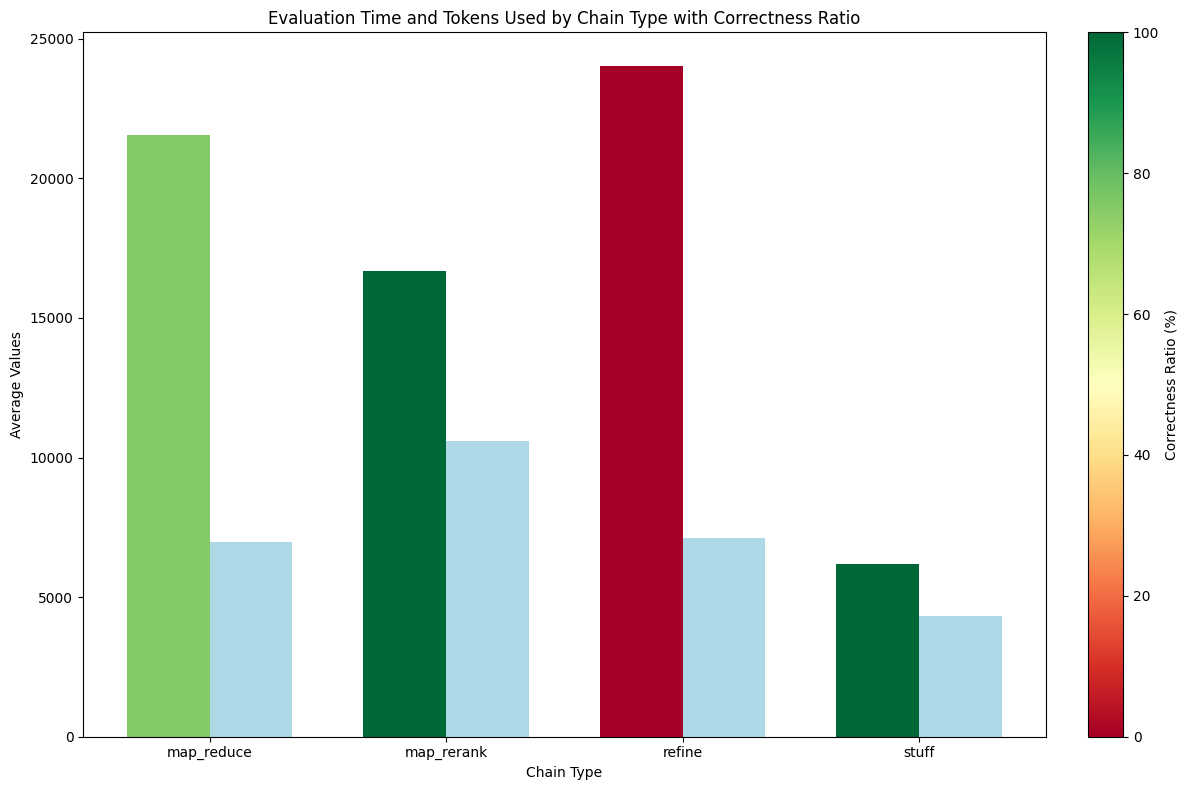

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors

# Assuming results_data is your list of ResultsData objects

# Convert results_data into a DataFrame
data = {
    "chain_type": [],
    "eval_time": [],
    "tokens_used": [],
    "is_correct": []
}

for result in results_data:
    for eval in result.eval:
        data["chain_type"].append(result.chain_type)
        data["eval_time"].append(eval["time"])
        data["tokens_used"].append(eval["tokens_used"])
        # 1 for correct, 0 otherwise
        data["is_correct"].append(1 if eval["result"] == "CORRECT" else 0)

df = pd.DataFrame(data)

# Calculate averages and correctness ratio
agg_data = df.groupby('chain_type').agg({
    'eval_time': 'mean',
    'tokens_used': 'mean',
    'is_correct': lambda x: np.mean(x) * 100  # correctness percentage
}).reset_index()

# Create a grouped bar chart with an additional bar for correct answers
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize correctness percentage for color mapping
norm = mcolors.Normalize(vmin=agg_data['is_correct'].min(), vmax=agg_data['is_correct'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

positions = np.arange(len(agg_data))
bar_width = 0.35

# Evaluation Time bars with color based on correctness ratio
for idx, row in agg_data.iterrows():
    ax.bar(idx - bar_width/2, row['eval_time'], bar_width, color=sm.to_rgba(row['is_correct']))

# Tokens Used bars
ax.bar(positions + bar_width/2, agg_data['tokens_used'], bar_width, color='lightblue')

# Correctness adjustment: create a dummy imshow for the colorbar reference
cb_ax = fig.add_axes([0, 0, 0.1, 0.1], visible=False)
cb_im = cb_ax.imshow([[0, 100]], cmap="RdYlGn")
cb_im.set_clim(vmin=0, vmax=100)
cbar = fig.colorbar(cb_im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
cbar.set_label('Correctness Ratio (%)')

# Final touches
ax.set_xlabel('Chain Type')
ax.set_ylabel('Average Values')
ax.set_title('Evaluation Time and Tokens Used by Chain Type with Correctness Ratio')
ax.set_xticks(positions)
ax.set_xticklabels(agg_data['chain_type'])
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
